# Puntaje Bancario: Aprobación de Crédito Mediante Redes Neuronales

En esta ocasión se busca desarrollar un protocolo de pruebas que permita encontrar la mejor arquitectura de red neuronal completamente conectada. En esta ocasión debe utilizar la librería SciKit-Learn (sklearn.neural_network) para diseñar cada red. Además, veremos algunos conceptos de _feature engineering_ para analizar los datos a nuestra disposición.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.

La fecha límite de entrega es el día **18 de octubre** y se realizará a través de Bloque Neón.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

Se tienen dos archivos:

`application_record.csv`: posee información general (puede observar los nombres de las columnas a continuación) sobre cada usuario, definido a partir de una ID única.

- ID: número de cliente
- CODE_GENDER: género
- FLAG_OWN_CAR:	posee un automóvil
- FLAG_OWN_REALTY: posee un inmueble
- CNT_CHILDREN:	cantidad de hijos
- AMT_INCOME_TOTAL:	ingresos anuales
- NAME_INCOME_TYPE: categoría de ingresos
- NAME_EDUCATION_TYPE: nivel educativo
- NAME_FAMILY_STATUS estado civil
- NAME_HOUSING_TYPE: forma de vivienda (e.g. renta, apartamento propio, ...)
- DAYS_BIRTH: fecha de nacimiento, en días hacia atrás desde la actualidad, -1 significa ayer

- DAYS_EMPLOYED: tiempo de empleo, en días hacia atrás desde la actualidad, -1 significa ayer. Si es positivo, el usuario se encuentra desempleado.
- FLAG_MOBIL: teléfono móvil
- FLAG_WORK_PHONE: teléfono de trabajo
- FLAG_PHONE: teléfono
- FLAG_EMAIL: email
- OCCUPATION_TYPE: ocupación
- CNT_FAM_MEMBERS: tamaño de familia


`credit_record.csv`:

- ID: número de cliente
- MONTHS_BALANCE: mes de registro
- ESTADO:
    - 0: 1-29 días atrasados
    - 1: 30-59 días atrasados
    - 2: 60-89 días atrasados
    - 3: 90-119 días atrasados
    - 4: 120-149 días atrasados
    - 5: Atrasados o incobrables, cancelaciones durante más de 150 días
    - C: cancelado ese mes X: sin préstamo durante el mes

In [2]:
data = pd.read_csv("creditCardScore/application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("creditCardScore/credit_record.csv", encoding = 'utf-8')

In [3]:
plt.rcParams['figure.facecolor'] = 'white'

In [4]:
data.tail()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0
438556,6842885,F,N,Y,0,121500.0,Working,Secondary / secondary special,Married,House / apartment,-18858,-1201,1,0,1,0,Sales staff,2.0


In [5]:
record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## Preparación de los Datos

### Etiquetas

Inicialmente, se concatenan ambas tablas mediante el tiempo de registro máximo (`MONTHS_BALANCE`) y la ID del cliente.

In [6]:
# find all users' account open month.
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

Los usuarios con mora durante más de 60 días se etiquerarán como `1`, de lo contrario, serán `0`.

In [7]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' 

In [8]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [9]:
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

Proporción de clases.

### Descriptores

+ Renombramiento de las Columnas

In [10]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [11]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna() # Retiramos los valores NaN

In [12]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

### Funciones Auxiliares

A continuación se crean algunas funciones que serán utilizadas más adelante.

Función `calc_iv` para obtener las variables IV (information value) y WoE (weight of evidence). Estas variables, de forma general, nos permiten conocer la importancia de cada feature disponible.

Puede encontrar más información en:
- https://www.kaggle.com/puremath86/iv-woe-starter-for-python
- https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

In [13]:
# Cálculo de IV
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                  *-                                          # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('El IV de esta variable es:',iv)
    print(df[feature].value_counts())
    return iv, data

In [14]:
# Codificación One-Hot
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [15]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [16]:
# Matriz de Confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')

### Descriptores Binarios

Se utilizará la función desarrollada anteriormente para realizar un análisis de cada uno de los descriptores binarios y **su influencia dentro de la predicción de cada clase**.

#### Género

In [17]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

0    15630
1     9504
Name: Gender, dtype: int64
El IV de esta variable es: 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


#### Posesión de un Automóvil

In [18]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

0    14618
1    10516
Name: Car, dtype: int64
El IV de esta variable es: 4.54248124999671e-06
0    14618
1    10516
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


#### Posesión de un Inmueble

In [19]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

1    16461
0     8673
Name: Reality, dtype: int64
El IV de esta variable es: 0.02744070350168343
1    16461
0     8673
Name: Reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


#### Posesión de un Teléfono

In [20]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

1    0.292791
0    0.707209
Name: phone, dtype: float64
El IV de esta variable es: 0.0005480495762639297
0    17775
1     7359
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


#### Posesión de Correo Electrónico (Email)

In [21]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

0    0.89934
1    0.10066
Name: email, dtype: float64
El IV de esta variable es: 1.7343581493999816e-05
0    22604
1     2530
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


#### Posesión de Teléfono para Trabajo

In [22]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

El IV de esta variable es: 0.002042429795148461
0    18252
1     6882
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


### Descriptores Continuos

#### Cantidad de Hijos

In [23]:
# Separamos aquellos que: no tienen hijos, tienen 1 hijo, tienen 2 o más hijos.

new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


In [24]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

El IV de esta variable es: 0.0011214542503301935
0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [25]:
new_data = convert_dummy(new_data,'ChldNo') # Adicionamos una Codificación One-Hot

In [26]:
new_data.head()

,ID,Gender,Car,Reality,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,...,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target,ChldNo_1,ChldNo_2More
2,5008806,1,1,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,...,0,0,0,Security staff,2.0,-29.0,No,0,0,0
3,5008808,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,-4.0,No,0,0,0
4,5008809,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,-26.0,No,0,0,0
5,5008810,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,-26.0,No,0,0,0
6,5008811,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,-38.0,No,0,0,0


#### Ingresos Anuales

Gráfica de Histograma para observar la distribución.

In [27]:
new_data['inc'] = new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: inc, dtype: int64


<AxesSubplot:ylabel='Frequency'>

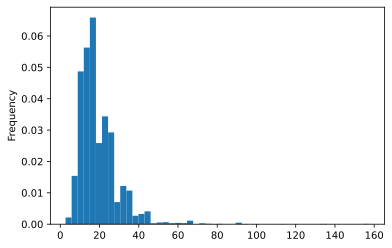

In [28]:
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [29]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

El IV de esta variable es: 0.0024219962221596752
low       8996
high      8244
medium    7894
Name: gp_inc, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_inc,high,8244,8096,148,0.328002,0.017952,0.327614,0.350711,-0.068126,0.001573
1,gp_inc,low,8996,8849,147,0.357922,0.016341,0.358085,0.348341,0.027588,0.000269
2,gp_inc,medium,7894,7767,127,0.314077,0.016088,0.314301,0.300948,0.043413,0.000580


In [30]:
new_data = convert_dummy(new_data,'gp_inc')

#### Edad

In [31]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

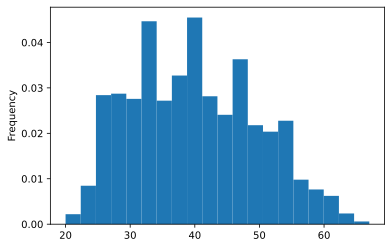

In [32]:
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [33]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

El IV de esta variable es: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


In [34]:
new_data = convert_dummy(new_data,'gp_Age')

#### Años de Trabajo

In [35]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean

<AxesSubplot:ylabel='Frequency'>

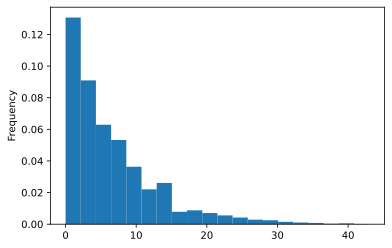

In [36]:
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [37]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

El IV de esta variable es: 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: gp_worktm, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,gp_worktm,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,gp_worktm,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,gp_worktm,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,gp_worktm,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


In [38]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'gp_worktm')

#### Tamaño de Familia

In [39]:
new_data['famsize'].value_counts(sort=False)

20.0        1
4.0      2576
7.0        18
2.0     12697
3.0      5216
15.0        3
6.0        51
5.0       307
9.0         2
1.0      4263
Name: famsize, dtype: int64

In [40]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

El IV de esta variable es: 0.006156138510778323
2        12697
3more     8174
1         4263
Name: famsizegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [41]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'famsizegp')

### Descriptores Categóricos

#### Forma de Ingresos

In [42]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

Pensioner                  13
Commercial associate     7052
Student                    10
State servant            2437
Working                 15622
Name: inctp, dtype: int64
Pensioner               0.000517
Commercial associate    0.280576
Student                 0.000398
State servant           0.096960
Working                 0.621549
Name: inctp, dtype: float64
El IV de esta variable es: 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: inctp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,inctp,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,inctp,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


In [43]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'inctp')

#### Tipo de Ocupación

In [44]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()         

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64
El IV de esta variable es: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [45]:
new_data = convert_dummy(new_data,'occyp')

In [46]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'houtp',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone',
       'email', 'famsize', 'begin_month', 'dep_value', 'target', 'ChldNo_1',
       'ChldNo_2More', 'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high',
       'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'worktm',
       'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk'],
      dtype='object')

#### Forma de Vivienda

In [47]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

El IV de esta variable es: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: houtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [48]:
new_data = convert_dummy(new_data,'houtp')

In [49]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents'],
      dtype='object')

#### Educación

In [50]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

El IV de esta variable es: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: edutp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [51]:
new_data = convert_dummy(new_data,'edutp')

In [52]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents',
       'edutp_Higher education', 'edutp_Incomplete higher',
       'edutp_Lower secondary'],
      dtype='object')

####  Estado Civil

In [53]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Separated               0.058367
Single / not married    0.137065
Widow                   0.023076
Married                 0.696626
Civil marriage          0.084865
Name: famtp, dtype: float64

In [54]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

El IV de esta variable es: 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: famtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [55]:
new_data = convert_dummy(new_data,'famtp')

In [56]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

## Utilidad de: IV y WoE

Puede leer el artículo a continuación para comprender un poco más sobre los conceptos de IV y WoE:

https://docs.tibco.com/pub/sfire-dsc/6.5.0/doc/html/TIB_sfire-dsc_user-guide/GUID-07A78308-525A-406F-8221-9281F4E9D7CF.html

La tabla a continuación fue tomada de la referencia indicada:

| IV| Ability to predict | 
|:------|:------:| 
| <0.02 | Bajo poder predictivo | 
|0.02~0.1 |Poder predictivo débil|
|0.1~0.3|Poder predictivo moderado|
|0.3~0.5|Poder predictivo fuerte|
|>0.5|Sospechosamente alto, revisar esta variable| 

In [57]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.065935
8,famtp,0.043137
11,worktmgp,0.040222
3,Reality,0.027441
1,Gender,0.025204
7,edutp,0.010362
9,houtp,0.007328
17,famsize,0.006156
16,occyp,0.00482
5,incgp,0.002422


# Predicción de Buen/Mal Cliente Mediante Redes Neuronales

+ Split Dataset

In [58]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

Se tomarán únicamente aquellas columnas preprocesadas y con un $IV>0.001$

In [59]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
              'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
              'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
              'houtp_Co-op apartment', 'houtp_Municipal apartment',
              'houtp_Office apartment', 'houtp_Rented apartment',
              'houtp_With parents','edutp_Higher education',
              'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
              'famtp_Separated','famtp_Single / not married','famtp_Widow']]

### SMOTE

Concepto: Synthetic Minority Over-Sampling Technique(`SMOTE`) utilizado para lidiar con datos desbalanceados. Puede encontrar más información en:

- http://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [60]:
Y = Y.astype('int')
sm = SMOTE()
X_balance,Y_balance = sm.fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

Separación de datos en conjuntos: entrenamiento y prueba.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

# \*Seleccione esta celda y luego la opción `Run All Above`\*

# PARTE 1

## Separación de Conjunto de Features

Teniendo en cuenta los resultados de IV obtenidos anteriormente, comprobaremos la capacidad predictiva de tres conjuntos de datos basados en la tabla anterior. Primero removeremos los últimos cuatro ('phone', 'inctp', 'email', 'Car'), y luego realizaremos la siguiente división:

- A. Primera mitad: 'agegp', 'famtp', 'worktmgp', 'Reality', 'Gender', 'edutp'
- B. Segunda mitad: 'houtp', 'famsize', 'occyp', 'incgp', 'wkphone', 'ChldNo'
- C. Todos los descriptores.

De acuerdo a estos nombres, utilice la siguiente lista para identificar aquellos solicitados en cada caso:
```
    'Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
    'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
    'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
    'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
    'occyp_officewk','famsizegp_1', 'famsizegp_3more',
    'houtp_Co-op apartment', 'houtp_Municipal apartment',
    'houtp_Office apartment', 'houtp_Rented apartment',
    'houtp_With parents','edutp_Higher education',
    'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
    'famtp_Separated','famtp_Single / not married','famtp_Widow'
```
### A. Top 6

In [62]:
# Se generan los nuevos conjuntos de entrenamiento y prueba para el caso A
X_train_subA = X_train[['gp_Age_highest', 'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'famtp_Civil marriage', 'famtp_Separated', 'famtp_Separated', 'famtp_Single / not married', 'famtp_Widow', 'gp_worktm_highest', 'gp_worktm_high', 'gp_worktm_medium', 'gp_worktm_low','Reality', 'Gender', 'edutp_Higher education', 'edutp_Incomplete higher', 'edutp_Lower secondary']]
X_test_subA = X_test[['gp_Age_highest', 'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'famtp_Civil marriage', 'famtp_Separated', 'famtp_Separated', 'famtp_Single / not married', 'famtp_Widow', 'gp_worktm_highest', 'gp_worktm_high', 'gp_worktm_medium', 'gp_worktm_low','Reality', 'Gender', 'edutp_Higher education', 'edutp_Incomplete higher', 'edutp_Lower secondary']]

X_train_subA.head()

,gp_Age_highest,gp_Age_highest,gp_Age_low,gp_Age_lowest,famtp_Civil marriage,famtp_Separated,famtp_Separated,famtp_Single / not married,famtp_Widow,gp_worktm_highest,gp_worktm_high,gp_worktm_medium,gp_worktm_low,Reality,Gender,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary
32515,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0.0,1.0,0,1,0
14471,0.0,0.0,1.0,0.0,0,1,1,0,0,0,0,0,0,0.0,0.0,0,0,0
16400,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,1,0.0,0.0,0,0,0
29956,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,1.0,0.0,0,0,0
39904,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0.0,1.0,0,0,0


### B. Últimos 6

In [63]:
# Se generan los nuevos conjuntos de entrenamiento y prueba para el caso B
X_train_subB = X_train[['houtp_Co-op apartment', 'houtp_Municipal apartment', 'houtp_With parents', 'famsizegp_1', 'famsizegp_3more', 'occyp_hightecwk', 'occyp_officewk', 'gp_inc_medium', 'gp_inc_high', 'wkphone', 'ChldNo_1', 'ChldNo_2More']]
X_test_subB = X_test[['houtp_Co-op apartment', 'houtp_Municipal apartment', 'houtp_With parents', 'famsizegp_1', 'famsizegp_3more', 'occyp_hightecwk', 'occyp_officewk', 'gp_inc_medium', 'gp_inc_high', 'wkphone', 'ChldNo_1', 'ChldNo_2More']]

X_train_subB.head()

,houtp_Co-op apartment,houtp_Municipal apartment,houtp_With parents,famsizegp_1,famsizegp_3more,occyp_hightecwk,occyp_officewk,gp_inc_medium,gp_inc_high,wkphone,ChldNo_1,ChldNo_2More
32515,0,0,1,0,0,0,0,1.0,0.000000,1.0,0.0,0.0
14471,0,0,0,1,0,0,0,0.0,1.000000,0.0,0.0,0.0
16400,0,0,0,0,0,0,0,0.0,1.000000,1.0,0.0,0.0
29956,0,0,0,1,0,0,0,0.0,1.000000,0.0,0.0,0.0
39904,0,0,0,0,1,0,0,0.0,0.157077,1.0,0.0,1.0


## Caso C

Acá simplemente tomaremos, no es necesario crear nuevas variables:
```
X_train_subC = X_train
X_test_subC = X_test
```

In [64]:
# Se generan los nuevos conjuntos de entrenamiento y prueba para el caso C 
X_train_subC = X_train
X_test_subC = X_test

X_train_subC.head()

,Gender,Reality,ChldNo_1,ChldNo_2More,gp_inc_medium,gp_inc_high,wkphone,gp_Age_high,gp_Age_highest,gp_Age_low,...,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
32515,1.0,0.0,0.0,0.0,1.0,0.000000,1.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,0,0
14471,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
16400,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
29956,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
39904,1.0,0.0,0.0,1.0,0.0,0.157077,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


# PARTE 2

Implementación de pruebas en los conjuntos de descriptores. A continuación debe implementar, inicialmente tres modelos de regresión logística, y posteriormente tres redes neuronales (2 capas escondidas, 20 neuronas en cada una). Observe los resultados y analice lo sucedido. Concluya sobre qué modelo es deseable teniendo en cuenta la factibilidad de implementación práctica y la matriz de confusión correspondiente.

## Regresión Logística

Inicialmente se probará un modelo de regresión logística para tener una referencia (también se conoce como _baseline_) y comprobar que un modelo de red neuronal permite obtener mejores resultados.

$$\log \left({p \over {1 - p}}\right) = {\beta _0} + {\beta _1}{x_1} +  \cdot  \cdot  \cdot  + {\beta _q}{x_q}$$

### Caso A

Precisión 0.6247

      0     1
0  3567  3847
1  1718  5696
[[3567 3847]
 [1718 5696]]


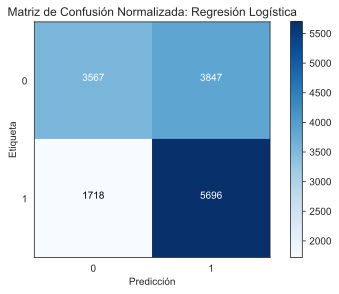

In [65]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subA, y_train) # Se ajusta el modelo con los datos del conjunto A #
y_predict = model.predict(X_test_subA) # Se realiza la predicción de etiquetas con los datos de prueba del conjunto A #

# Variable para guardar la precisión del caso A
precLogCasoA = round(accuracy_score(y_test, y_predict),5)

print(f'Precisión {precLogCasoA}\n')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')

## Caso B

Precisión 0.57432

      0     1
0  4298  3116
1  3196  4218
[[4298 3116]
 [3196 4218]]


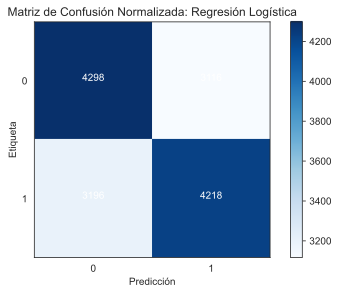

In [66]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subB, y_train) # Se ajusta el modelo con los datos del conjunto B #
y_predict = model.predict(X_test_subB) # Se realiza la predicción de etiquetas con los datos de prueba del conjunto B #

# Variable para guardar la precisión del caso B
precLogCasoB = round(accuracy_score(y_test, y_predict),5)

print(f'Precisión {precLogCasoB}\n')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')


## Caso C

Precisión 0.65403

      0     1
0  4325  3089
1  2041  5373
[[4325 3089]
 [2041 5373]]


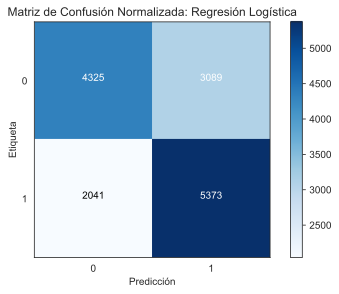

In [67]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subC, y_train) # Se ajusta el modelo con los datos del conjunto C #
y_predict = model.predict(X_test_subC) # Se realiza la predicción de etiquetas con los datos de prueba del conjunto C #

# Variable para guardar la precisión del caso C
precLogCasoC = round(accuracy_score(y_test, y_predict),5)

print(f'Precisión {precLogCasoC}\n')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')


## Red Neuronal, Perceptrón Multicapa

Ahora utilice la función `MLPClassifier` de la librería SciKit-Learn para desarrollar una red neuronal que permita mejorar el rendimiento del clasificador _baseline_ desarrollado.

### Caso A

Precisión 0.63859
      0     1
0  4871  2543
1  2816  4598
[[4871 2543]
 [2816 4598]]


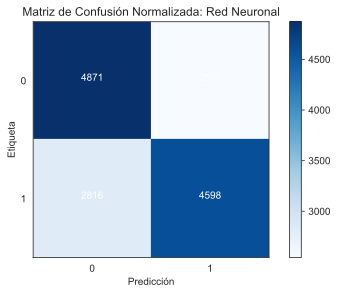

In [68]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(2, 20), activation='relu', random_state=1) # Se inicializa un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train_subA, y_train) # Se ajusta el modelo con los datos del conjunto A #
y_predict = model.predict(X_test_subA) # Se realiza la predicción de etiquetas con los datos de prueba del conjunto A #

# Variable para guardar la precisión del caso A (Neural Network)
precNNCasoA = round(accuracy_score(y_test, y_predict),5)

print(f'Precisión {precNNCasoA}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Caso B

Precisión 0.63198
      0     1
0  5782  1632
1  3825  3589
[[5782 1632]
 [3825 3589]]


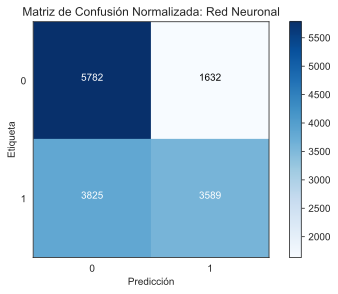

In [69]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(2, 20), activation='relu', random_state=1) # Se inicializa un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train_subB, y_train) # Se ajusta el modelo con los datos del conjunto B #
y_predict = model.predict(X_test_subB) # Se realiza la predicción de etiquetas con los datos de prueba del conjunto B #

# Variable para guardar la precisión del caso B (Neural Network)
precNNCasoB = round(accuracy_score(y_test, y_predict),5)

print(f'Precisión {precNNCasoB}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Caso C

Precisión 0.7266
      0     1
0  5616  1798
1  2256  5158
[[5616 1798]
 [2256 5158]]


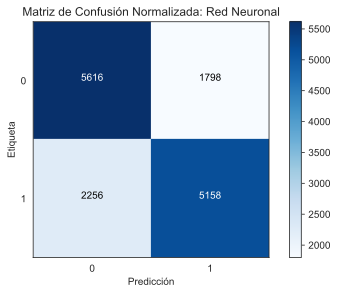

In [70]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(2, 20), activation='relu', random_state=1) # Se inicializa un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train_subC, y_train) # Se ajusta el modelo con los datos del conjunto C #
y_predict = model.predict(X_test_subC) # Se realiza la predicción de etiquetas con los datos de prueba del conjunto C #

# Variable para guardar la precisión del caso C (Neural Network)
precNNCasoC = round(accuracy_score(y_test, y_predict),5)

print(f'Precisión {precNNCasoC}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

In [81]:
# Se genera una tabla con las precisiones de cada caso para poder ver la información resumida de manera organizada.
precisiones = [[precLogCasoA, precLogCasoB, precLogCasoC, precNNCasoA, precNNCasoB, precNNCasoC]]
dfPrecisiones = pd.DataFrame(precisiones, columns=['Precisión LogReg Caso A', 'Precisión LogReg Caso B', 'Precisión LogReg Caso C', 'Precisión NN Caso A', 'Precisión NN Caso B', 'Precisión NN Caso C'])

dfPrecisiones

,Precisión LogReg Caso A,Precisión LogReg Caso B,Precisión LogReg Caso C,Precisión NN Caso A,Precisión NN Caso B,Precisión NN Caso C
0,0.6247,0.57432,0.65403,0.63859,0.63198,0.7266


### Conclusiones Parte 2

Se pueden hacer las siguientes observaciones:

- Para los tres casos de separación de datos, el entrenamiento del modelo de **regresión logística** entregó en todos los casos una *menor* precisión, lo que es de esperarse, pues este modelo de regresión no es tan robusto como una red neuronal. De hecho, se puede ver la regresión logística como una red neuronal de una capa con una sola neurona de activación sigmodial. Comparando esto con una red neuronal de dos capas y 20 neuronas en cada capa, es claro que, aunque la red neuronal de 2 capas y 20 neuronas por capa toma más tiempo para entrenar, entrega una mejor precisión porque se hace un mayor aprendizaje al tener varias neuronas y varias capas.

- Mirando solo los tres casos entrenados con un modelo de **regresión logística**, se puede notar que el Caso C, en donde se entrenó el modelo usando todos los descriptores de las clases, fue el que entregó la mejor precisión de los tres, y esto puede ser debido al hecho de que, teniendo en cuenta todas las características del modelo se tiene un mejor criterio para el clasificador binario, así clasificando correctamente más datos en comparación con los otros dos casos. También se puede notar que el caso A entregó una mejor precisión que el caso B, y esto esto se debe al hecho de que en el caso A se entrenó el modelo usando solo los descriptores que tuvieron un mayor IV (Information Value). Al tener este mayor IV, son características más valiosas/importantes al momento de realizar la clasificación entre las clases y por tanto, se obtiene una mejor precisión en la clasificación en comparación con el caso B, en donde los descriptores usados no tienen un valor de IV tan alto en comparación con los descriptroes del caso A.

- Mirando solo los tres casos entrenados con un modelo de **red neuronal** de dos capas y 20 neuronas por capa, se puede notar el mismo fenómeno que se observó con la regresión logística: la precisión es mayor cuando se usan solo los descriptores de mayor IV en comparación con el uso de descriptores con menor IV. También se puede notar que estas dos precisiones (casos A y B) fueron considerablemente mayores a la obtenida en los mismos casos de la regresión logísitca, por las razones expuestas en el ítem anterior. Nuevamente se puede observar que la precisión para el modelo de red neuronal entrenado usando todos los descriptores entregó la mejor precisión de todos los casos, y esto se puede deber nuevamente al hecho de que, teniendo en cuenta todos los descriptores del modelo se tiene un mejor criterio para el clasificador binario, así clasificando correctamente más datos en comparación con los otros dos casos.

# PARTE 3

Los resultados obtenidos para las redes neuronales anteriores únicamente corresponden a una arquitectura. Un proceso necesario e importante en casos de estudio como este es la búsqueda de hiperparámetros, en este caso, el número de neuronas más adecuado (al menos dentro de cierto rango, este proceso también se conoce como [GridSearch](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)).

**Divida el conjunto de datos de prueba en dos mitades: datos de validación y datos de prueba. Utilice los datos de validación para realizar una evaluación preliminar de cada modelo.** Utilice `train_test_split` para esta parte.

Utilice todos los descriptores para esta prueba y realice las siguientes búsquedas:

- Caso A: 1 capa escondida $\times$ {5, 10, 20, 50, 100} neuronas.
- Caso B: 2 capas escondidas $\times$ {5, 10, 20, 50, 100} neuronas.
- Caso C: 3 capas escondidas $\times$ {5, 10, 20, 50, 100} neuronas.

Utilice `matplotlib.pyplot` para graficar la precisión en los datos de validación, seleccione el mejor modelo, y obtenga una evaluación final para esta selección utilizando los datos de prueba.

### Caso A

In [86]:
# Se parten los datos de prueba en dos subconjuntos: datos de validación y datos de prueba (versión 2).
X_valid, X_test_2, y_valid, y_test_2 = train_test_split(X_test, y_test, 
                                                    stratify=y_test, test_size=0.5,
                                                    random_state = 10086)

# Se declaran los diferentes números de capas y neuronas que se van a validar.
numCapas = [1, 2, 3]
numNeus = [5, 10, 20, 50, 100]

In [1]:
# Lista para guardar las precisiones para el caso A.
precisionesCasoA = []

# # # # Implemente un ciclo FOR para entrenar cada una de las configuraciones solicitadas # # # #
for neuronas in numNeus:
    model = MLPClassifier(hidden_layer_sizes=(numCapas[0], neuronas), activation='relu', random_state=1) 
    model.fit(X_train, y_train) 
    y_predict = model.predict(X_valid) 
    prec = round(accuracy_score(y_valid, y_predict),5)
    precisionesCasoA.append(prec) # Al entrenar cada configuración posible, se agrega la precisión del modelo a la lista.

# Se grafican las precisiones para cada configuración solicitada.
print(precisionesCasoA)
plt.plot(numNeus, precisionesCasoA)
plt.grid()
plt.title('Precisiones para el caso A')
plt.xlabel('# de neuronas')
plt.ylabel('Precisión')

NameError: name 'numNeus' is not defined

### Caso B

[0.68613, 0.67683, 0.73105, 0.7096, 0.71203]


Text(0, 0.5, 'Precisión')

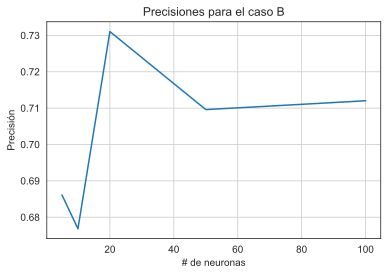

In [88]:
# Lista para guardar las precisiones para el caso B.
precisionesCasoB = []

# # # # Implemente un ciclo FOR para entrenar cada una de las configuraciones solicitadas # # # #
for neuronas in numNeus:
    model = MLPClassifier(hidden_layer_sizes=(numCapas[1], neuronas), activation='relu', random_state=1) 
    model.fit(X_train, y_train) 
    y_predict = model.predict(X_valid) 
    prec = round(accuracy_score(y_valid, y_predict),5)
    precisionesCasoB.append(prec) # Al entrenar cada configuración posible, se agrega la precisión del modelo a la lista.

# Se grafican las precisiones para cada configuración solicitada.
print(precisionesCasoB)
plt.plot(numNeus, precisionesCasoB)
plt.grid()
plt.title('Precisiones para el caso B')
plt.xlabel('# de neuronas')
plt.ylabel('Precisión')

### Caso C

[0.69881, 0.73739, 0.72741, 0.72269, 0.71338]


Text(0, 0.5, 'Precisión')

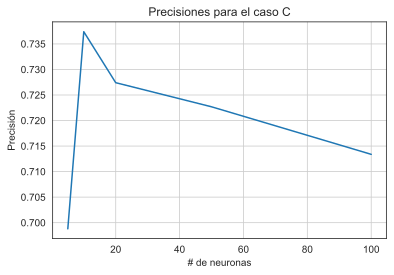

In [89]:
# Lista para guardar las precisiones para el caso C.
precisionesCasoC = []

# # # # Implemente un ciclo FOR para entrenar cada una de las configuraciones solicitadas # # # #
for neuronas in numNeus:
    model = MLPClassifier(hidden_layer_sizes=(numCapas[2], neuronas), activation='relu', random_state=1) 
    model.fit(X_train, y_train) 
    y_predict = model.predict(X_valid) 
    prec = round(accuracy_score(y_valid, y_predict),5)
    precisionesCasoC.append(prec) # Al entrenar cada configuración posible, se agrega la precisión del modelo a la lista.

# Se grafican las precisiones para cada configuración solicitada.
print(precisionesCasoC)
plt.plot(numNeus, precisionesCasoC)
plt.grid()
plt.title('Precisiones para el caso C')
plt.xlabel('# de neuronas')
plt.ylabel('Precisión')

## Ahora se determina de forma automática cuál fue la configuración de red neuronal óptima.

In [106]:
# Se genera una lista de las listas creadas previamente, para luego crear una sola lista con todas las precisiones.
# Se sabe que los primeros 5 elementos de la lista corresponden al caso A, los siguientes 5 al caso B y los últimos 5
# al caso C.
lista = [precisionesCasoA, precisionesCasoB, precisionesCasoC]
lista2 = list(itertools.chain.from_iterable(lista))

# Se encuentra la precisión más alta con su respectivo índice dentro de la lista
mejor = np.max(lista2)
index_mejor = lista2.index(mejor)

# Si el índice es menor o igual a 5, quiere decir que la mejor precisión ocurrió en el caso A
# y por lo tanto, la cantidad de capas óptima es 1. Se guarda el número de capas y neuronas por
# capa óptimas en variables correspondientes.
if index_mejor <= 5:
    capasOpt = numCapas[0]
    indice_mejor = precisionesCasoA.index(mejor)
    neuronas_opt = numNeus[indice_mejor]
# Si el índice es mayor a 10, quiere decir que la mejor precisión ocurrió en el caso C
# y por lo tanto, la cantidad de capas óptima es 3. Se guarda el número de capas y neuronas por
# capa óptimas en variables correspondientes.
elif index_mejor > 10:
    capasOpt = numCapas[2]
    indice_mejor = precisionesCasoC.index(mejor)
    neuronas_opt = numNeus[indice_mejor]
# Si el índice está entre 5 y 10, quiere decir que la mejor precisión ocurrió en el caso B
# y por lo tanto, la cantidad de capas óptima es 2. Se guarda el número de capas y neuronas por
# capa óptimas en variables correspondientes.
else:
    capasOpt = numCapas[1]
    indice_mejor = precisionesCasoB.index(mejor)
    neuronas_opt = numNeus[indice_mejor]

# Se muestran los resultados óptimos.
print(f'Número óptimo de capas: {capasOpt}')
print(f'Número óptimo de neuronas por capa: {neuronas_opt}')

Número óptimo de capas: 3
Número óptimo de neuronas por capa: 10


# Se decidió escoger una arquitectura de red neuronal con 3 capas escondidas y 10 neuronas por capa porque, con los datos de validación, se obtuvo la mayor precisión usando esta arquitectura.

### Gráficas Evaluativas

In [107]:
# Se entrena el modelo nuevamente, usando las cantidades óptimas de capas y número de neuronas por capa hallado previamente 
# y se prueban con los datos de prueba (versión 2).
model = MLPClassifier(hidden_layer_sizes=(capasOpt, neuronas_opt), activation='relu', random_state=1) 
model.fit(X_train, y_train) 
y_predict = model.predict(X_test_2) 
prec = round(accuracy_score(y_test_2, y_predict),5)

# Se muestra la precisión obtenida con los datos de prueba (versión 2).
print(f'Precisión con parámetros óptimos ({capasOpt} capas escondidas, {neuronas_opt} neuronas por capa): {prec}')

Precisión con parámetros óptimos (3 capas escondidas, 10 neuronas por capa): 0.73348


      0     1
0  2226  1481
1   495  3212
[[2226 1481]
 [ 495 3212]]


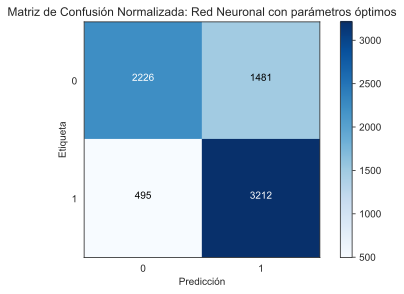

In [109]:
# Se muestra la matriz de confusión para el modelo probado con los datos de prueba (versión 2) y los parámetros óptimos.
print(pd.DataFrame(confusion_matrix(y_test_2, y_predict)))

plot_confusion_matrix(confusion_matrix(y_test_2, y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal con parámetros óptimos')

## Se comprobó con los datos de prueba que la elección de parámetros fue óptima, pues se obtuvo un valor de precisión alto y la cantidad de errores tipo 1 y tipo 0 es mucho menor comparada con todas las clasificaciones correctas que la red neuronal arrojó.


# Bono (2 puntos)

Implemente el mejor modelo de red neuronal. Desarrolle el método de **_backpropagation_** para realizar el entrenamiento de la red sin utilizar ningún tipo de librería que tenga funciones prestablecidas con objetivos de apoyo en el tema de Machine Learning. Puede utilizar Numpy, Pandas, etc. NO puede utilizar: SciKit-Learn, Tensorflow/Keras, PyTorch, etc.

El bono debe estar COMPLETO y se debe observar una curva de aprendizaje a través de las iteraciones que permita obtener resultados aceptables con respecto a la red definida a partir de SciKit-Learn. De lo contrario, no se tomará como válido.

In [75]:
# # # # Implemente el método de backpropagation para la arquitectura seleccionada # # # #
# 
# 
# 
# 
# 
# 
# ... 